##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import numpy as np
import string
from bs4 import BeautifulSoup
import unidecode
from word2number import w2n
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC


from sklearn import metrics
from numpy import mean
from numpy import std


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
train_data = pd.read_csv("Train.csv", sep=',')
train_data.drop(train_data.filter(regex="Unnamed"), axis =1, inplace= True)
train_data.drop(train_data.filter(regex="id"), axis =1, inplace= True)
test_data = pd.read_csv("Test.csv", sep=',')
test_data.drop(train_data.filter(regex="Unnamed"), axis =1, inplace= True)
test_data.drop(train_data.filter(regex="id"), axis =1, inplace= True)


In [3]:
#remove URL and @xxx from text
def to_lower(text):
    text = text.lower()
    return text
def remove_url_and_at(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    return text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#remove extra whitespaces from text
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#remove html tags from text
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#remove accented characters from text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
#expand contractions in text
def expand_contractions(text):
    #expand shortened words
    text = contractions.fix(text)
    return text

# this fuction is from <https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f>
# standardize emoji
def emotion(text):
    text = re.sub(r':\)|:D|: \)|=\)|:-\)', " :) ", text)
    text = re.sub(r':\(|: \(|:-\(', " :(  ", text)                      
    return text

#remove punctuation beside !&?
def remove_punc_and_number(text):
    punctuation = list(string.punctuation)
    punctuation.remove('?')
    punctuation.remove('!')
    for i in range(len(text)):
        if text[i] in punctuation:
            if i+1 <= len(text)-1:
                if (text[i] == ":") and (text[i+1] == "(" or text[i+1] == ")"):
                    continue
            if i >= 1:
                if (text[i] == ")" or text[i] == "(") and (text[i-1] == ':'):
                    continue
            text = text.replace(text[i], ' ')
    text = re.sub(r'[0-9]+', '', text)
    return text


#extract !&?
def create_whitespace(text):
    text = re.sub(r'\?+', ' ? ', text)
    text = re.sub(r'!+', ' ! ', text)              
    return text

#remove words have <=2 length
def remove_shortwords(filtered_sentence):
    return_list=[]
    for word in filtered_sentence:
        if len(word) > 2:
            return_list.append(word)
    return  return_list

#lemitization
def lemmetize_print(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

# remove stop words from text
# exclude words "no","not",from stopwords list
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')

def remove_stopwords(text):
    text_lst = text.split(" ")
    for word in text_lst:
        if word in stop_words:
            text_lst.remove(word)
    return text_lst

def remove_deplicated_charac(text):
    text = re.sub("(.)\\1{2,}", "\\1", text)
    return text

def remove_deplicated_charac2(text):
    text_lst = text.split(" ")
    for i in range(len(text_lst)):
        text_lst[i] = re.sub("^(.)\\1{1,}","\\1" ,text_lst[i])
    return " ".join(text_lst)

In [4]:
#preprocessing text
from collections import Counter
import pycountry


frequency = Counter()
month = ["january", "february", "march", "april", "june", "july", "august", "september", "october", "november","december"]
number =["one","two","three","four","five","six","seven","eight","nine","ten"]
countries= []
for p in pycountry.countries:
    p = p.name.lower()
    countries.append(p)
    
    
def clean_text_instance(df):
    for i in range(len(df["text"])):
        text = df["text"][i]
        text = to_lower(text)
        text = df["text"][i]
        text = contractions.fix(text) 
        text = remove_deplicated_charac(text)
        text = remove_deplicated_charac2(text)
        text = remove_accented_chars(text)
        text = remove_url_and_at(text)
        text = strip_html_tags(text)
        text = emotion(text)
        text = remove_punc_and_number(text)
        text = create_whitespace(text)
        text = remove_whitespace(text)
        text = lemmetize_print(text)

        #word_tokens = word_tokenize(text)
        stop_word_removed_list = remove_stopwords(text) 
        new_filtered_sentence = remove_shortwords(stop_word_removed_list)
        #record number of occurance for unique words
        frequency.update(new_filtered_sentence)
        new_sentence = " ".join(new_filtered_sentence)
        df.iloc[i,df.columns.get_loc('text')] = new_sentence
    #keep only words with more than 2 occurace
    for i in range(len(df["text"])):
        word_list = df["text"][i].split()
        new_word_list = [word for word in word_list if frequency[word] >3]
        new_word_list = [word for word in word_list if frequency[word] <7000]
        new_word_list = [word for word in word_list if word not in month]
        new_word_list = [word for word in word_list if word not in number]
        new_word_list = [word for word in word_list if word not in countries]
        new_sentence = " ".join(new_word_list)
        df.iloc[i,df.columns.get_loc('text')]= new_sentence 

In [5]:
clean_text_instance(test_data)
clean_text_instance(train_data)

In [6]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
y_train_ori = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [7]:
#accuracy
DUM_train_acc = []
SVM_train_acc =[]
LR_train_acc =[]
MNB_train_acc =[]
Stacking_train_acc=[]


#validation accuracy
DUM_valid_acc = []
SVM_valid_acc =[]
LR_valid_acc =[]
MNB_valid_acc =[]
Stacking_valid_acc=[]


#percision
DUM_percision =[]
SVM_percision =[]
LR_percision =[]
MNB_percision =[]
Stacking_percision =[]


DUM_percision_weighted=[]
SVM_percision_weighted =[]
LR_percision_weighted =[]
MNB_percision_weighted =[]
Stacking_percision_weighted=[]


#recall
DUM_recall =[]
SVM_recall =[]
LR_recall =[]
MNB_recall =[]
Stacking_recall =[]


DUM_recall_weighted =[]
SVM_recall_weighted =[]
LR_recall_weighted =[]
MNB_recall_weighted =[]
Stacking_recall_weighted=[]


#F1 score
DUM_F1 = []
SVM_F1 =[]
LR_F1 =[]
MNB_F1 =[]
Stacking_F1=[]

In [8]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import collections

y_train_ori = train_data.iloc[:,-1]
counter_list =[]
counter_list2=[]

kf = KFold(n_splits=4, random_state=None, shuffle=False)
for train_index, val_index in kf.split(list(X_train_raw), list(y_train_ori)):
    
    X_train = np.array(X_train_raw)[train_index]
    X_val = np.array(X_train_raw)[val_index]
    y_train = y_train_ori[train_index]
    y_val = y_train_ori[val_index]
    
    #Base mode: 0-R
    DUMclf = DummyClassifier(strategy ="most_frequent")
    DUMclf.fit(X_train, y_train)
    DUM_train_acc.append(DUMclf.score(X_train, y_train))
    DUM_valid_acc.append(DUMclf.score(X_val, y_val))
    #precision
    y_val_pred0 = DUMclf.predict(X_val)
    DUM_percision.append(precision_score(y_val, y_val_pred0, average ="micro"))
    DUM_percision_weighted.append(precision_score(y_val, y_val_pred0, average ="weighted"))
    #recall = tp/(tp+fn)
    DUM_recall.append(recall_score(y_val, y_val_pred0, average ="micro"))
    DUM_recall_weighted.append(recall_score(y_val, y_val_pred0, average ="weighted"))
    #f1
    DUM_F1.append(f1_score(y_val, y_val_pred0, average ="weighted"))
    
    counter = dict(collections.Counter(y_train))
    counter_list.append(counter)
    
    #Bow
    BoW_vectorizer = CountVectorizer(analyzer ='word', ngram_range =(1,2))
    #Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
    X_train_BoW = BoW_vectorizer.fit_transform(X_train)
    #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
    X_val_BoW = BoW_vectorizer.transform(X_val)
    

    #remove feature with low variance
    selector =VarianceThreshold(threshold  =0.0001)
    X_train_BoW_var = selector.fit_transform(X_train_BoW,y_train)
    X_val_BoW_var = selector.transform(X_val_BoW)
 
    #feature selection select K best feature
    select_k_best = SelectKBest(f_classif, k=3000)
    X_train_BoW_var_selectk = select_k_best.fit_transform(X_train_BoW_var,y_train)
    X_val_BoW_var_selectk = select_k_best.transform(X_val_BoW_var)

    
    #oversampling
    oversample = SMOTE()
    X_train_BoW_var_selectk, y_train = oversample.fit_resample(X_train_BoW_var_selectk, y_train)
    
    
    counter_over = dict(collections.Counter(y_train))
    counter_list2.append(counter_over)
    """
    
    define the classifiers
    
    
    """
    
 
    
    """define the SVM model"""
    SVMclf = SVC(kernel = 'linear',
                 C = 2,
                 decision_function_shape = 'ovo',
                class_weight = 'balanced')
    SVMclf.fit(X_train_BoW_var_selectk,y_train)
    #train accuracy
    SVM_train_acc.append(SVMclf.score(X_train_BoW_var_selectk, y_train))
    #test accuracy
    SVM_valid_acc.append(SVMclf.score(X_val_BoW_var_selectk, y_val))
    #precision
    y_val_pred1 = SVMclf.predict(X_val_BoW_var_selectk)
    SVM_percision.append(precision_score(y_val, y_val_pred1, average ="micro"))
    SVM_percision_weighted.append(precision_score(y_val, y_val_pred1, average ="weighted"))
    #recall = tp/(tp+fn)
    SVM_recall.append(recall_score(y_val, y_val_pred1, average ="micro"))
    SVM_recall_weighted.append(recall_score(y_val, y_val_pred1, average ="weighted"))
    #f1
    SVM_F1.append(f1_score(y_val, y_val_pred1, average ="weighted"))
    
    
    
    """define the logistic regression model"""
    LRclf = LogisticRegression(random_state = 42,
                               solver = 'saga', 
                               multi_class = 'multinomial',
                               C = 1.5,
                               max_iter = 500,
                              class_weight = 'balanced')
    LRclf.fit(X_train_BoW_var_selectk,y_train)
    LR_train_acc.append(LRclf.score(X_train_BoW_var_selectk, y_train))
    LR_valid_acc.append(LRclf.score(X_val_BoW_var_selectk, y_val))
    #Macro metrics of the classifier
    y_val_pred2 = LRclf.predict(X_val_BoW_var_selectk)
    LR_percision.append(precision_score(y_val, y_val_pred2, average ="micro"))   
    LR_percision_weighted.append(precision_score(y_val, y_val_pred2, average ="weighted"))
    #recall = tp/(tp+fn)
    LR_recall.append(recall_score(y_val, y_val_pred2, average ="micro"))
    LR_recall_weighted.append(recall_score(y_val, y_val_pred2, average ="weighted"))                                       
    #f1
    LR_F1.append(f1_score(y_val, y_val_pred2, average ="weighted"))     
                                 
    
    """define a naive bayes model"""
    MNBclf= MultinomialNB(alpha =1,
                         fit_prior =False)
    MNBclf.fit(X_train_BoW_var_selectk,y_train)
    #accuracy
    MNB_train_acc.append(MNBclf.score(X_train_BoW_var_selectk, y_train))
    MNB_valid_acc.append(MNBclf.score(X_val_BoW_var_selectk, y_val))
    #Macro metrics of the classifier
    y_val_pred3 = MNBclf.predict(X_val_BoW_var_selectk)
    MNB_percision.append(precision_score(y_val, y_val_pred3, average ="micro"))   
    MNB_percision_weighted.append(precision_score(y_val, y_val_pred3, average ="weighted"))
    #recall = tp/(tp+fn)
    MNB_recall.append(recall_score(y_val, y_val_pred3, average ="micro"))
    MNB_recall_weighted.append(recall_score(y_val, y_val_pred3, average ="weighted"))                                       
    #f1
    MNB_F1.append(f1_score(y_val, y_val_pred3, average ="weighted"))   
    
    
    #stacking
    estimators =[("svm",SVMclf),("mnb", MNBclf)]
    Stackingclf = StackingClassifier(estimators =estimators, final_estimator = LRclf)
    Stackingclf.fit(X_train_BoW_var_selectk, y_train)
    #accuracy
    Stacking_train_acc.append(Stackingclf.score(X_train_BoW_var_selectk, y_train))
    Stacking_valid_acc.append(Stackingclf.score(X_val_BoW_var_selectk, y_val))
    #Macro metrics of the classifier
    y_val_pred4 = Stackingclf.predict(X_val_BoW_var_selectk)  
    Stacking_percision.append(precision_score(y_val, y_val_pred4, average ="micro")) 
    Stacking_percision_weighted.append(precision_score(y_val, y_val_pred4, average ="weighted"))
    #recall = tp/(tp+fn)
    Stacking_recall.append(recall_score(y_val, y_val_pred4, average ="micro")) 
    Stacking_recall_weighted.append(recall_score(y_val, y_val_pred4, average ="weighted"))                                       
    #f1
    Stacking_F1.append(f1_score(y_val, y_val_pred4, average ="weighted"))


/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zongchaoxie/opt/anaconda3/lib/pyt

Text(0, 0.5, 'Number of labels')

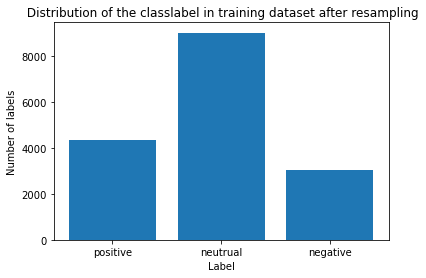

In [10]:
# see class distribution before oversampling
counter =dict(counter_list[3])
Label = ["positive", "neutrual", "negative"]
data =[counter["positive"], counter["neutral"],counter["negative"]]

plt.bar(Label,data)
plt.title(" Distribution of the classlabel in training dataset after resampling")
plt.xlabel("Label")
plt.ylabel("Number of labels")

Text(0, 0.5, 'Number of labels')

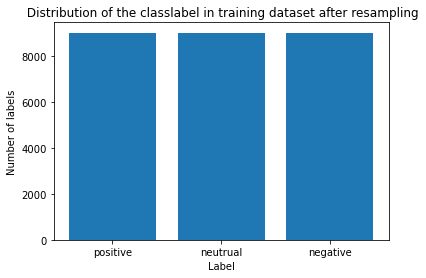

In [11]:
# see class distribution after oversampling
counter =dict(counter_list2[3])
Label = ["positive", "neutrual", "negative"]
data =[counter["positive"], counter["neutral"],counter["negative"]]

plt.bar(Label,data)
plt.title(" Distribution of the classlabel in training dataset after resampling")
plt.xlabel("Label")
plt.ylabel("Number of labels")

In [12]:
import pandas as pd
accuracy = {"Training accuracy": [np.mean(DUM_train_acc), np.mean(SVM_train_acc), np.mean(LR_train_acc), 
                                   np.mean(MNB_train_acc), np.mean(Stacking_train_acc)],
            "Validation accuracy": [np.mean(DUM_valid_acc), np.mean(SVM_valid_acc), np.mean(LR_valid_acc), 
                                    np.mean(MNB_valid_acc), np.mean(Stacking_valid_acc)]}
acc_table = pd.DataFrame(accuracy, index =['0R',
                                'SVM',
                                'LR',
                                'MNB',
                                'Stacking'])
evaluation_metrics = {"Weighted Recall": [np.mean(DUM_recall_weighted), np.mean(SVM_recall_weighted), np.mean(LR_recall_weighted),
      np.mean(MNB_recall_weighted), np.mean(Stacking_recall_weighted)],
                     "Weighted Precision": [np.mean(DUM_percision_weighted), np.mean(SVM_percision_weighted), np.mean(LR_percision_weighted),
      np.mean(MNB_percision_weighted), np.mean(Stacking_percision_weighted)],
                     "F1": [np.mean(DUM_F1), np.mean(SVM_F1), np.mean(LR_F1), np.mean(MNB_F1), np.mean(Stacking_F1)]}
metric_table = pd.DataFrame(evaluation_metrics, index =['0R', 'SVM',
                                'LR',
                                'MNB',
                                'Stacking'])
                                                                                          
display(acc_table)                                                                                          
display(metric_table)                                                                                          
                                                                                          
                                                                                          
                                                                                          

Training accuracy  Validation accuracy
0R                 0.580635             0.580638
SVM                0.746317             0.563710
LR                 0.739841             0.571736
MNB                0.674215             0.559581
Stacking           0.713523             0.552334

Weighted Recall  Weighted Precision        F1
0R               0.580638            0.339865  0.427919
SVM              0.563710            0.585879  0.570200
LR               0.571736            0.594279  0.577823
MNB              0.559581            0.613397  0.566201
Stacking         0.552334            0.599650  0.559047

/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


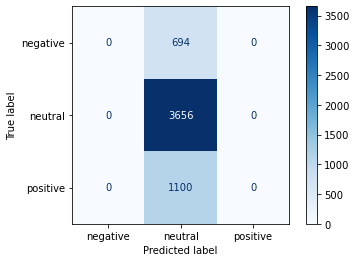

In [13]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(DUMclf, X_val_BoW_var_selectk, y_val, cmap = plt.cm.Blues)

/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


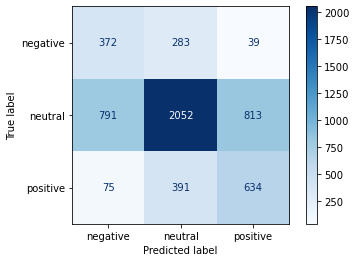

In [14]:
#confusion mtrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(SVMclf, X_val_BoW_var_selectk, y_val, cmap = plt.cm.Blues)

/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


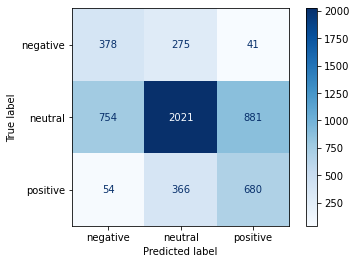

In [15]:
#confusion mtrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(LRclf, X_val_BoW_var_selectk, y_val, cmap = plt.cm.Blues)

/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


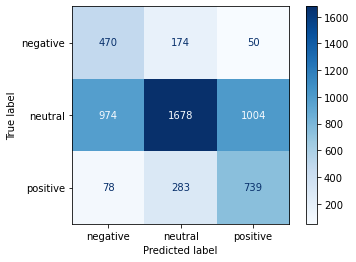

In [16]:
#confusion mtrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(MNBclf, X_val_BoW_var_selectk, y_val, cmap = plt.cm.Blues)

/Users/zongchaoxie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


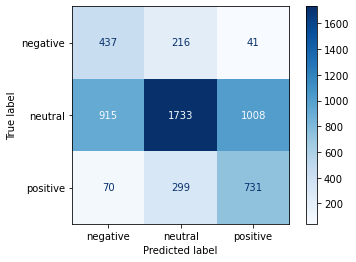

In [17]:
#confusion mtrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(Stackingclf, X_val_BoW_var_selectk, y_val, cmap = plt.cm.Blues)

fit the whole training set to get the final model used for prediction.

In [18]:
#Bow
BoW_vectorizer = CountVectorizer(analyzer ='word', ngram_range =(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)
X_test_BoW = BoW_vectorizer.transform(X_test_raw)
#remove feature with low variance
from sklearn.feature_selection import VarianceThreshold
selector =VarianceThreshold(threshold  =0.0001)
X_train_BoW_var = selector.fit_transform(X_train_BoW,y_train_ori)
X_test_BoW_var = selector.transform(X_test_BoW)
print("Train feature space size (using BoW):",X_train_BoW_var.shape)

#feature selection select K best feature
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
select_k_best = SelectKBest(f_classif, k=3000)
X_train_BoW_var_selectk = select_k_best.fit_transform(X_train_BoW_var,y_train_ori)
X_test_BoW_var_selectk = select_k_best.transform(X_test_BoW_var)
print("Train feature space size (using BoW):",X_train_BoW_var_selectk.shape)

Train feature space size (using BoW): (21802, 15683)
Train feature space size (using BoW): (21802, 3000)


In [19]:
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train_BoW_var_selectk, y_train_ori)
Stackingclf.fit(X_train_over, y_train_over)
y_test_pred = Stackingclf.predict(X_test_BoW_var_selectk)
Predict_val_label = pd.DataFrame(y_test_pred)
test_data["sentiment"] = y_test_pred
test_data[["id","sentiment"]].to_csv("oversampling_3000_withdays_fitwhole.csv", encoding='utf-8', index=False)